In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import graphviz
sns.set_theme(style="darkgrid", palette=None) # making the seaborn as default template for matplotlib

from pandas.api.types import infer_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
# from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from xgboost import plot_tree
from xgboost import XGBRegressor

***
### Train.csv
***

In [28]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check Target Distribution

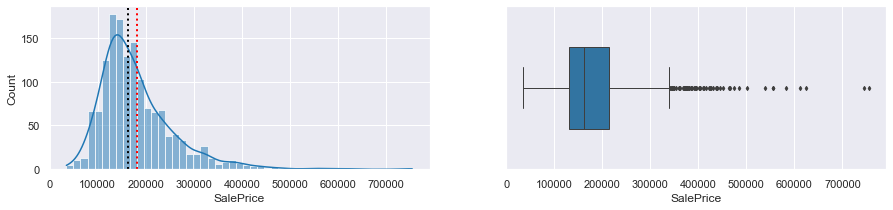

In [29]:
fig, ax = plt.subplots(1, 2, figsize= (15,3))

sns.histplot(ax=ax[0], data=train, x='SalePrice', kde= True)
sns.boxplot (ax= ax[1], data=train, x='SalePrice', linewidth= 1, fliersize=3, width=0.5)
ax[0].axvline(x=train['SalePrice'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[0].axvline(x=train['SalePrice'].median(), ymax= 1, color= 'black',linestyle='dotted', linewidth=2)


In [30]:
# # It shows that it has outlier on the right-end, hence we need to remove 1% from total data
# df = train

# q = df['SalePrice'].quantile(0.99)
# df = df[df['SalePrice']<q]
# df = df.reset_index(drop= True)

# train.shape[0]-df.shape[0] # Remove 15 data on right-end

In [31]:
df = train
log_saleprice= np.log(df['SalePrice'])
df['log_saleprice']= log_saleprice

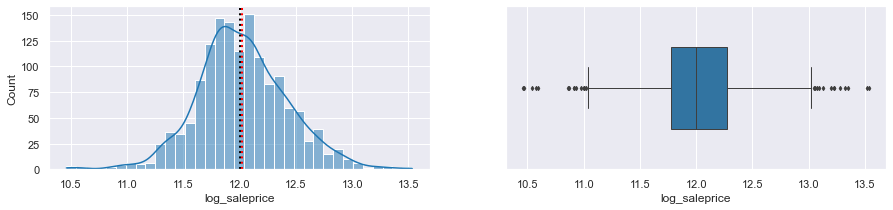

In [32]:
fig, ax = plt.subplots(1, 2, figsize= (15,3))

sns.histplot(ax=ax[0], data=df, x='log_saleprice', kde= True)
sns.boxplot (ax= ax[1], data=df, x='log_saleprice', linewidth= 1, fliersize=3, width=0.5)
ax[0].axvline(x=df['log_saleprice'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[0].axvline(x=df['log_saleprice'].median(), ymax= 1, color= 'black',linestyle='dotted', linewidth=2)

### Descriptive Data

In [33]:
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,3,4,4,NaN,NaN,NaN,9,6,NaN,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,3,157,49,NaN,NaN,NaN,1267,1198,NaN,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890,12.024051
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883,0.399452
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000,10.460242
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000,11.775097
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000,12.001505
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000,12.273731


In [34]:
unique_value = pd.DataFrame(df.describe(include='all').loc['mean',:])
df_categorical= unique_value.loc[unique_value['mean'].isnull()].index
df_numerical= unique_value.loc[unique_value['mean'].notnull()].index

df_categorical= pd.DataFrame(df_categorical,columns=['Categorical'])
df_numerical= pd.DataFrame(df_numerical,columns=['Numerical'])

df_type= df_categorical.join(df_numerical)
df_type.head()

,Categorical,Numerical
0,MSZoning,Id
1,Street,MSSubClass
2,Alley,LotFrontage
3,LotShape,LotArea
4,LandContour,OverallQual


In [35]:
sum_null= pd.DataFrame(df.isnull().sum())
sum_null.columns =['null_value']

sum_null= sum_null[sum_null['null_value']>0]
sum_null = sum_null.reset_index()
sum_null.columns = ['Feature','null_value']

sum_null.head()

,Feature,null_value
0,LotFrontage,259
1,Alley,1369
2,MasVnrType,8
3,MasVnrArea,8
4,BsmtQual,37


In [36]:
null_list = []

for i in sum_null['Feature'].values :
    if i in df_type['Categorical'].values :
        null_list.append('Cat')
    if i in df_type['Numerical'].values :
        null_list.append('Num')
        
null_list = pd.DataFrame(null_list)
null_list.columns = ['Type']
sum_null= sum_null.join(null_list)

sum_null.head()

,Feature,null_value,Type
0,LotFrontage,259,Num
1,Alley,1369,Cat
2,MasVnrType,8,Cat
3,MasVnrArea,8,Num
4,BsmtQual,37,Cat


In [37]:
sum_null_num= sum_null[sum_null['Type'] == 'Num']
sum_null_cat= sum_null[sum_null['Type'] == 'Cat']

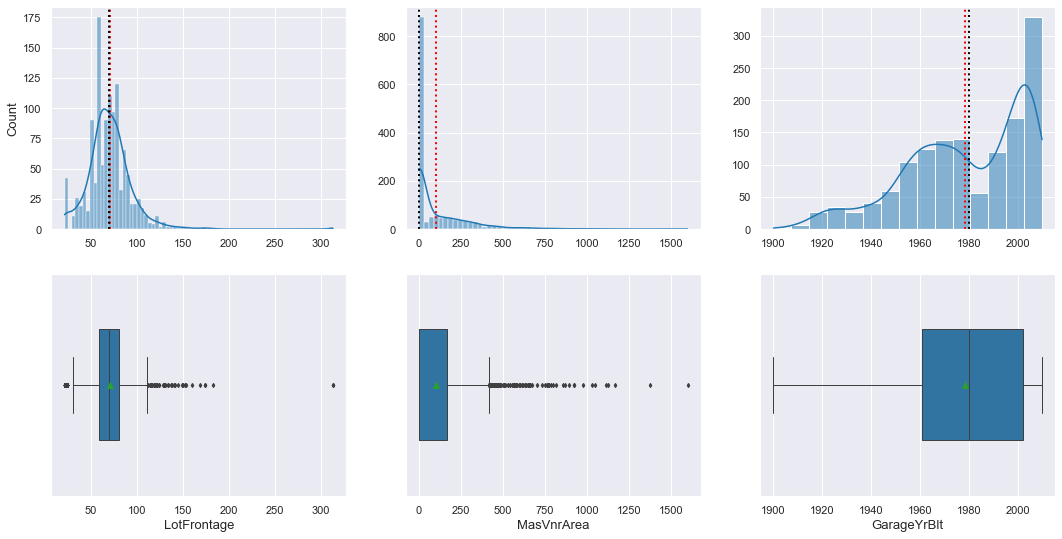

In [38]:
# For missing value in Numerical Category
fig, ax = plt.subplots(2, 3, figsize= (18,9))

for i,j in list(enumerate(sum_null_num['Feature'])):
    sns.histplot(ax=ax[0,i], data=df, x=j, kde= True)
    sns.boxplot (data=df, x=j, linewidth= 1, ax= ax[1,i],showmeans= True, fliersize=3, width=0.5)
    ax[0,i].axvline(x=df[j].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
    ax[0,i].axvline(x=df[j].median(), ymax= 1, color= 'black',linestyle='dotted', linewidth=2)
    
    ax[0,i].set_xlabel(None)
    ax[1,i].set_xlabel(j, fontsize = 13)
    ax[0,0].set_ylabel('Count', fontsize = 13)
    ax[0,1].set_ylabel(None)
    ax[0,2].set_ylabel(None)


In [39]:
# Dealing with missing value
df['LotFrontage'] = df['LotFrontage'].replace(np.nan, np.mean(df['LotFrontage']))
df['MasVnrArea'] = df['MasVnrArea'].replace(np.nan, 0)
df['Alley'] = df['Alley'].replace(np.nan, 'NA')
df['MasVnrType'] = df['MasVnrType'].replace(np.nan, 'None')
df['BsmtExposure'] = np.where(df['Id'] == 949, 'No', df['BsmtExposure'])
df['BsmtExposure'] = df['BsmtExposure'].replace(np.nan, 'NA')
df['BsmtFinType2'] = np.where(df['Id'] == 333, 'Unf', df['BsmtFinType2'])
df['BsmtFinType2'] = df['BsmtFinType2'].replace(np.nan, 'NA')
df['BsmtFinType1'] = df['BsmtFinType1'].replace(np.nan, 'NA')
df['BsmtQual'] = df['BsmtQual'].replace(np.nan, 'NA')
df['BsmtCond'] = df['BsmtCond'].replace(np.nan, 'NA')
df['Electrical'] = df['Electrical'].replace(np.nan, 'SBrkr')
df['FireplaceQu'] = df['FireplaceQu'].replace(np.nan, 'NA')
df['GarageType'] = df['GarageType'].replace(np.nan, 'NA')
df['GarageYrBlt'] = df['GarageYrBlt'].replace(np.nan, np.mean(df['GarageYrBlt']))
df['GarageFinish'] = df['GarageFinish'].replace(np.nan, 'NA')
df['GarageQual'] = df['GarageQual'].replace(np.nan, 'NA')
df['GarageCond'] = df['GarageCond'].replace(np.nan, 'NA')
df['PoolQC'] = df['PoolQC'].replace(np.nan, 'NA')
df['Fence'] = df['Fence'].replace(np.nan, 'NA')
df['MiscFeature'] = df['MiscFeature'].replace(np.nan, 'NA')


In [40]:
df_num = df[list(df_type['Numerical'][1:37])]
df_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [41]:
# Column type checker

# for i in list(df_cat.columns):
#     bbb = infer_dtype(df_cat[i])
#     print(i, bbb)
   

In [42]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

In [43]:
cat_ohe = ohe.fit_transform(df[list(df_type['Categorical'])])

In [44]:
categorical_cols = df_type['Categorical']

In [45]:
df_cat_ohe = pd.DataFrame(cat_ohe,columns= ohe.get_feature_names(input_features = categorical_cols))
df_cat_ohe

C:\Users\Wahyudi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
df_prep = df_num.join(df_cat_ohe)
df_preprocessed_log = df_prep.join(df['log_saleprice'])
df_preprocessed =  df_prep.join(df['SalePrice'])

### Training

In [159]:
# This is for fit the model to predict log_saleprice
# X_log = df_preprocessed_log.iloc[:,:-1]
X = df_preprocessed.iloc[:,:-1]

y_log = df_preprocessed_log.iloc[:,-1]
y = df_preprocessed.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 365, test_size = 0.2) 
# X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, random_state= 365, test_size = 0.2) 

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, random_state= 365, test_size = 0.2) 
# if this is for categorical value we can use argument stratify = y

In [200]:
# For log_saleprice as Target
xgbr_log = xgb.XGBRegressor(base_score =0.5, 
                        verbosity=0,
                        booster= 'gbtree',
                        gamma= 0,
                        max_depth= 6,
                        min_child_weight = 1,
                        reg_lambda = 1,
                        learning_rate= 0.2 
                       )

# For Saleprice as Target
xgbr = xgb.XGBRegressor(base_score =0.5, 
                        verbosity=0,
                        booster= 'gbtree',
                        gamma= 0,
                        max_depth= 6,
                        min_child_weight = 1,
                        reg_lambda = 1,
                        learning_rate= 0.2 
                       )

In [201]:
# define the datasets to evaluate each iteration
# for log_saleprice as Target
evalset = [(X_train_log, y_train_log), (X_test_log,y_test_log)]
xgbr_log.fit(X_train,y_train_log,
         verbose= False,
         early_stopping_rounds = 10,
         eval_metric  = 'rmse',
         eval_set = evalset)
train_score_log = xgbr_log.score(X_train_log, y_train_log) # measuring how good the model predicting the training data

# for SalePrice as Target
evalset = [(X_train, y_train), (X_test,y_test)]
xgbr.fit(X_train,y_train,
         verbose= False,
         early_stopping_rounds = 10,
         eval_metric  = 'rmse',
         eval_set = evalset)
train_score = xgbr.score(X_train, y_train) # measuring how good the model predicting the training data

print(train_score_log)
print(train_score)

C:\Users\Wahyudi\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Wahyudi\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Wahyudi\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Wahyudi\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
 

0.9979165941167103
0.9976018864138702


***

In [202]:
def plot_learning_curves(estimator, X, y, title, y_lim):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv = 10, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
    train_scores_std = np.sqrt(-train_scores).std(axis=1)
    validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
    validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

    plt.style.use('seaborn')   
    plt.plot(train_sizes, train_scores_mean, "r-+", linewidth=2,label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, "b-", linewidth=3, label = 'Validation error')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="b",
    )

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for ' + title + ' as target'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend(loc="best")
    plt.ylim(0,y_lim)

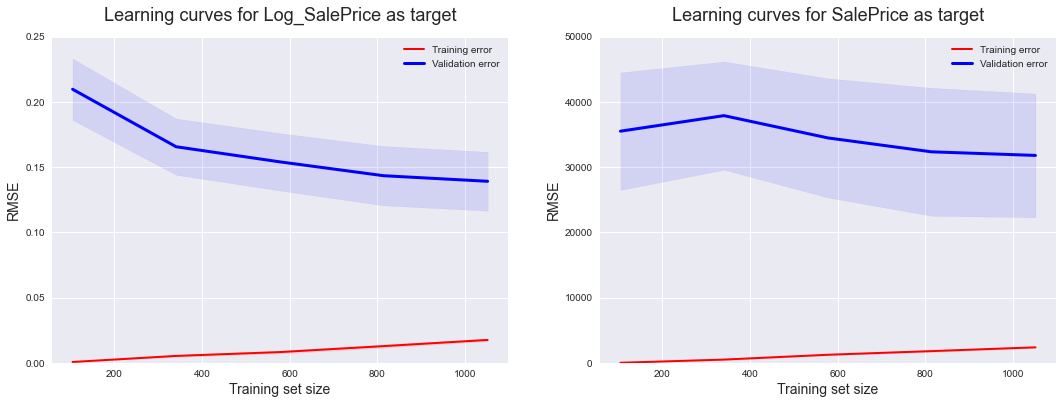

In [203]:
### Plotting the two learning curves ###
plt.figure(figsize = (18,6))
estimator =[xgbr_log,xgbr]
titles = ['Log_SalePrice','SalePrice']

# train_sizes = [1, 10, 20, 50, 100, 200, 500, 856]

for model, X,y, title,i,ylim in [(xgbr_log, X_train_log, y_train_log, titles[0], 1, 0.25), 
                                 (xgbr, X_train, y_train, titles[1],2, 50000)]:
    plt.subplot(1,2,i)
    plot_learning_curves(model, X, y, title, ylim)


In [204]:
train_sizes, train_scores, validation_scores = learning_curve(
        xgbr_log, X_train_log, y_train_log, cv = 10, scoring = 'neg_mean_squared_error')

train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
train_scores_std = np.sqrt(-train_scores).std(axis=1)
validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

print(np.exp(train_scores_mean)[-1])
print(np.exp(validation_scores_mean)[-1])

1.0176883642886307
1.1492747554500846


* **In the left plot, errors has huge gap but both training and validation error is converging, On the last training set the difference between training and validation error is about 1.15/1.02 ~ 1.13. This means that the validation error is 13% bigger than training error.  It is an overfitting model. Three ways to improve current model:**

 * **Add more training set. The two curves would continue to get closer for the validation curve doesn't plateau at the maximum training set size.**

 * **Increase the regularization. This should decrease the variance and increase the bias.** 

 * **Reduce the numbers of features in the training data. This should decrease the variance and increase the bias.**

* **In the right plot,errors has huge gap and both training and validation error is not converging,  the RMSE on the training data is much lower than that in the left plot. It is an overfitting model.**

* **This means that the polynomial model performs much better on the training data than on the validation data. It is an overfitting model. Three ways to improve current model:**



In [ ]:
### Plotting the two learning curves ###
plt.figure(figsize = (18,6))
# train_sizes = [1, 10, 20, 50, 100, 200, 500, 856]
# titles = ['linear regression','polynomial regression']
for X, title,i in [(X_train,titles[0], 1), (X_poly2_train,titles[1],2)]:
    plt.subplot(1,2,i)
    plot_learning_curves(lin_reg, X, target, train_sizes, 5, title)

***
***
***

(0.0, 50000.0)

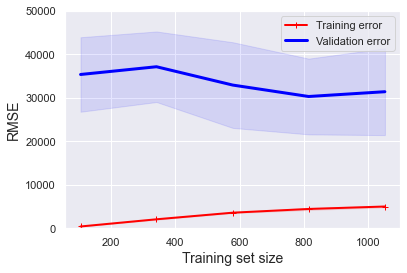

In [169]:
train_sizes, train_scores, validation_scores = learning_curve(
        xgbr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')

train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
train_scores_std = np.sqrt(-train_scores).std(axis=1)
validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

# plt.style.use('seaborn')   
plt.plot(train_sizes, train_scores_mean, "r-+", linewidth=2,label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, "b-", linewidth=3, label = 'Validation error')
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    validation_scores_mean - validation_scores_std,
    validation_scores_mean + validation_scores_std,
    alpha=0.1,
    color="b",
)

plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
# title = 'Learning curves for a ' + name + ' model'
# plt.title(title, fontsize = 18, y = 1.03)
plt.legend(loc="best")
plt.ylim(0,50000)

In [101]:
print(train_scores_mean)
print(train_scores_std)
print(validation_scores_mean)
print(validation_scores_std)

[ 418.57740851 2071.66179803 3591.28568011 4446.77779587 5009.93960516]
[  0.80818358  98.81532735  95.448951   236.8456295  195.69092761]
[35369.92636923 37150.27299897 32936.87040258 30307.22680365
 31408.65145996]
[8568.28953737 8109.9684464  9851.94385271 8708.95192101 9979.15314484]


***

In [51]:
cv_score_log = cross_val_score(xgbr_log, X_train_log, y_train_log, cv= 10)
cv_score = cross_val_score(xgbr, X_train, y_train, cv= 10)

print(cv_score_log.mean())
print(cv_score.mean())

0.877164642448597
0.8134715627637531


### Testing

In [52]:
y_pred_log = xgbr_log.predict(X_test_log)
y_pred = xgbr.predict(X_test)

In [53]:
# test_score = xgbr_log.score(X_test, y_test) # this is the r2 score

[Text(0, 0.5, 'RMSE'), Text(0, 0.5, 'RMSE')]

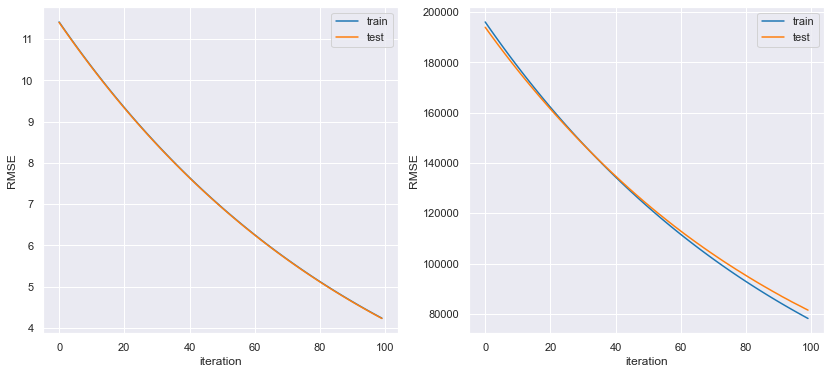

In [155]:
fig, ax1 = plt.subplots(1,2,sharex='col', figsize= (14,6))

results_log = xgbr_log.evals_result()
results = xgbr.evals_result()

ax1[0].plot(results_log['validation_0']['rmse'], label='train')
ax1[0].plot(results_log['validation_1']['rmse'], label='test')
ax1[0].legend()


ax1[1].plot(results['validation_0']['rmse'], label='train')
ax1[1].plot(results['validation_1']['rmse'], label='test')
ax1[1].legend()

plt.setp(ax1, xlabel='iteration')
plt.setp(ax1, ylabel='RMSE')



In [ ]:
mse_test_log = mean_squared_error(y_test_log, y_pred_log)
rmse_test_log = np.sqrt(mse_test_log)
print('RMSE log_saleprice :%.3f'% rmse_test_log)
r2_test_log = r2_score(y_test_log, y_pred_log)
print("R square log_saleprice: %.3f"% r2_test_log)

print('-' * 80)

# mse_test_exp = mean_squared_error(y_test, y_pred)
# rmse_test_exp = np.sqrt(mse_test)
print('RMSE saleprice ($) :%.3f'% np.exp(rmse_test_log))
r2_test_exp_log = r2_score(np.exp(y_test_log), np.exp(y_pred_log))
print("R square saleprice: %.3f"% r2_test_exp)


In [ ]:
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
print('RMSE log_saleprice :%.3f'% rmse_test)
r2_test = r2_score(y_test, y_pred)
print("R square log_saleprice: %.3f"% r2_test)

print('-' * 80)

# mse_test_exp = mean_squared_error(y_test, y_pred)
# rmse_test_exp = np.sqrt(mse_test)
print('RMSE saleprice ($) :%.3f'% np.exp(rmse_test))
r2_test_exp = r2_score((y_test), (y_pred))
print("R square saleprice: %.3f"% r2_test_exp)


ValueError: Found input variables with inconsistent numbers of samples: [1168, 1460]

In [ ]:
def plot_learning_curves(estimator, X, y, train_sizes, cv, name):
    train_sizes, train_scores, validation_scores = learning_curve(
                        estimator, X, y, train_sizes =train_sizes, 
                        cv = cv, scoring= 'neg_mean_squared_error')
    
    train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
    train_scores_std = np.sqrt(-train_scores).std(axis=1)
    validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
    validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

    plt.style.use('seaborn')   
    plt.plot(train_sizes, train_scores_mean, "r-+", linewidth=2,label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, "b-", linewidth=3, label = 'Validation error')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="b",
    )

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + name + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend(loc="best")
    plt.ylim(0,12000)

In [ ]:
learning_curve(
        estimator, X_train, y_log, train_sizes =train_sizes, cv = cv, scoring = 'neg_mean_squared_error')

### Residual check

In [ ]:
residual_test = y_test_log - y_pred_log

# since the prediction we get is in the log form, we can revert it to its actual value
residual_test_exp = np.exp(y_test) - np.exp(y_pred)

# Converting the log_saleprice back into SalePrice
plt.scatter(np.exp(y_test), np.exp(y_pred), alpha= 0.2)
plt.title('Residual',size=13)
plt.xlabel('y_test', size = 13)
plt.ylabel('y_pred', size = 13)

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', lw=0.5, scalex=False, scaley=False)

plt.show

In [ ]:
sns.histplot((residual_test_exp), kde= True)
plt.title('Residual PDF',size=13)
plt.xlabel('residual')

In [ ]:
fig, ax = plt.subplots(1,1,sharex='col', sharey='row', figsize= (9,4))

plt.scatter(x= X_test['LotArea'],y = residual_test_exp,alpha=0.2)
plt.axhline(y=0, color= 'black', lw=0.5)
plt.title('Residual vs LotArea',size=13)
plt.xlabel('LotArea', fontdict=None, labelpad=None)
plt.ylabel('Residual', fontdict=None, labelpad=None)

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.88)  

plt.show()


***

In [ ]:
residual_test = y_test - y_pred

# since the prediction we get is in the log form, we can revert it to its actual value
residual_test_exp = np.exp(y_test) - np.exp(y_pred)

# Converting the log_saleprice back into SalePrice
plt.scatter(np.exp(y_test), np.exp(y_pred), alpha= 0.2)
plt.title('Residual',size=13)
plt.xlabel('y_test', size = 13)
plt.ylabel('y_pred', size = 13)

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', lw=0.5, scalex=False, scaley=False)

plt.show

### Data Performance

In [ ]:
# Since we predict the logarthmic value, we need to find the exponential value to get the actual value
df_pf = pd.DataFrame(np.exp(y_pred), columns =['Prediction'])
df_pf['Target_(SalePrice)'] = np.exp(y_test.reset_index(drop=True))
df_pf['Residual'] = df_pf['Target_(SalePrice)'] - df_pf['Prediction']
df_pf['Difference%'] = df_pf['Residual']/df_pf['Target_(SalePrice)']*100

df_pf.head(5)

In [ ]:
df_pf.describe()

In [ ]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_pf.sort_values(by = ['Difference%'])

***
### Test.csv
***

In [ ]:
test = pd.read_csv('test.csv')
test.head()

In [ ]:
df_test = test
df_test.describe(include='all')

In [ ]:
# Separating the numerical and categorical data
unique_value_test = pd.DataFrame(df_test.describe(include='all').loc['mean',:])
df_test_categorical= unique_value_test.loc[unique_value['mean'].isnull()].index
df_test_numerical= unique_value_test.loc[unique_value['mean'].notnull()].index

df_test_categorical= pd.DataFrame(df_test_categorical,columns=['Categorical'])
df_test_numerical= pd.DataFrame(df_test_numerical,columns=['Numerical'])

df_test_type= df_test_categorical.join(df_test_numerical)
df_test_type.head()

In [ ]:
test_sum_null= pd.DataFrame(df_test.isnull().sum())
test_sum_null.columns =['null_value']

test_sum_null= test_sum_null[test_sum_null['null_value']>0]
test_sum_null = test_sum_null.reset_index()
test_sum_null.columns = ['Feature','null_value']

test_sum_null.head()

In [ ]:
test_null_list = []

for i in test_sum_null['Feature'].values :
    if i in df_test_type['Categorical'].values :
        test_null_list.append('Cat')
    if i in df_test_type['Numerical'].values :
        test_null_list.append('Num')
        
test_null_list = pd.DataFrame(test_null_list)
test_null_list.columns = ['Type']
test_sum_null= test_sum_null.join(test_null_list)

test_sum_null.head()

In [ ]:
sum_null_num

In [ ]:
test_sum_null_num= test_sum_null[test_sum_null['Type'] == 'Num']
test_sum_null_cat= test_sum_null[test_sum_null['Type'] == 'Cat']
test_sum_null_num
# this time we get more missing value than in train.csv
# even so, we still only fill the missing value like in train.csv feature before 

In [ ]:
# Dealing with missing value
df_test['LotFrontage'] = df_test['LotFrontage'].replace(np.nan, np.mean(df_test['LotFrontage']))
df_test['MasVnrArea'] = df_test['MasVnrArea'].replace(np.nan, 0)
df_test['Alley'] = df_test['Alley'].replace(np.nan, 'NA')
df_test['MasVnrType'] = df_test['MasVnrType'].replace(np.nan, 'None')
df_test['BsmtQual'] = np.where(df_test['Id'] == 2218, 'TA', df_test['BsmtQual'])
df_test['BsmtQual'] = np.where(df_test['Id'] == 2219, 'TA', df_test['BsmtQual'])
df_test['BsmtQual'] = df_test['BsmtQual'].replace(np.nan, 'NA')
df_test['BsmtCond'] = np.where(df_test['Id'] == 2041, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = np.where(df_test['Id'] == 2186, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = np.where(df_test['Id'] == 2525, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = df_test['BsmtCond'].replace(np.nan, 'NA')
df_test['BsmtExposure'] = np.where(df_test['Id'] == 1488, 'No', df_test['BsmtExposure'])
df_test['BsmtExposure'] = np.where(df_test['Id'] == 2349, 'No', df_test['BsmtExposure'])
df_test['BsmtExposure'] = df_test['BsmtExposure'].replace(np.nan, 'NA')
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].replace(np.nan, 'NA')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].replace(np.nan, 'NA')
df_test['FireplaceQu'] = df_test['FireplaceQu'].replace(np.nan, 'NA')
df_test['GarageType'] = df_test['GarageType'].replace(np.nan, 'NA')
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].replace(np.nan, np.mean(df_test['GarageYrBlt']))
df_test['GarageFinish'] = np.where(df_test['Id'] == 2577, 'TA', df_test['GarageFinish'])
df_test['GarageFinish'] = np.where(df_test['Id'] == 2041, 'TA', df_test['GarageFinish'])
df_test['GarageFinish'] = df_test['GarageFinish'].replace(np.nan, 'NA')
df_test['GarageQual'] = df_test['GarageQual'].replace(np.nan, 'NA')
df_test['GarageCond'] = df_test['GarageCond'].replace(np.nan, 'NA')
df_test['PoolQC'] = df_test['PoolQC'].replace(np.nan, 'NA')
df_test['Fence'] = df_test['Fence'].replace(np.nan, 'NA')
df_test['MiscFeature'] = df_test['MiscFeature'].replace(np.nan, 'NA')


In [ ]:
df_test_num = df_test[list(df_test_type['Numerical'][1:37])]
df_test_num.columns

In [ ]:
cat_test_ohe = ohe.fit_transform(df_test[list(df_test_type['Categorical'])])

In [ ]:
categorical_test_cols = df_test_type['Categorical']

In [ ]:
df_test_cat_ohe = pd.DataFrame(cat_test_ohe,columns= ohe.get_feature_names(input_features = categorical_test_cols))
df_test_cat_ohe

In [ ]:
df_test_preprocessed = df_test_num.join(df_test_cat_ohe)

In [ ]:
# We will call data from test.csv as 'new'
X_new = df_test_preprocessed

In [ ]:
# Get missing columns in the training test
missing_cols = set(X_train.columns) - set(X_new.columns)
# Add a missing column in test.csv set with default value equal to 0
for i in missing_cols:
    X_new[i] = 0
# Ensure the order of column in the test set is in the same order than in train.csv
X_new = X_new[X_train.columns]

In [ ]:
y_new_pred = xgbr_log.predict(X_new)
y_new_pred

### Prediction

In [ ]:
# Prediction for test.csv
df_test_pf = pd.DataFrame(np.exp(y_new_pred), columns =['Test_Prediction'])
df_test_pf.insert(0,'Id',df_test['Id'].values)

df_test_pf.head(5)